<a href="https://colab.research.google.com/github/veroonia/Calorie-Estimation/blob/main/Calorie_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Standard library
import os
import glob
import random

# Numerical and data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Image processing
import cv2
from skimage.feature import hog, local_binary_pattern

# Dataset utilities
import kagglehub

# Parallelization and persistence
from joblib import dump, load, Parallel, delayed

# Machine learning – preprocessing and model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Machine learning – models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Machine learning – evaluation
from sklearn.metrics import accuracy_score, classification_report


In [2]:
path = kagglehub.dataset_download("trolukovich/food11-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.08G/1.08G [00:09<00:00, 122MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/trolukovich/food11-image-dataset/versions/1


In [3]:
DATASET_PATH = path

classes = sorted([
    d for d in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, d))
])

print("Classes:", classes)
print("Number of classes:", len(classes))

Classes: ['evaluation', 'training', 'validation']
Number of classes: 3


A balanced visual inspection was performed to verify class diversity and image quality before applying image processing techniques.

In [4]:
DATASET_PATH = path
SPLIT = "training"

split_dir = os.path.join(DATASET_PATH, SPLIT)

classes = sorted([
    d for d in os.listdir(split_dir)
    if os.path.isdir(os.path.join(split_dir, d))
])

print("Split:", SPLIT)
print("Number of food classes:", len(classes))
print("Classes:", classes)

Split: training
Number of food classes: 11
Classes: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


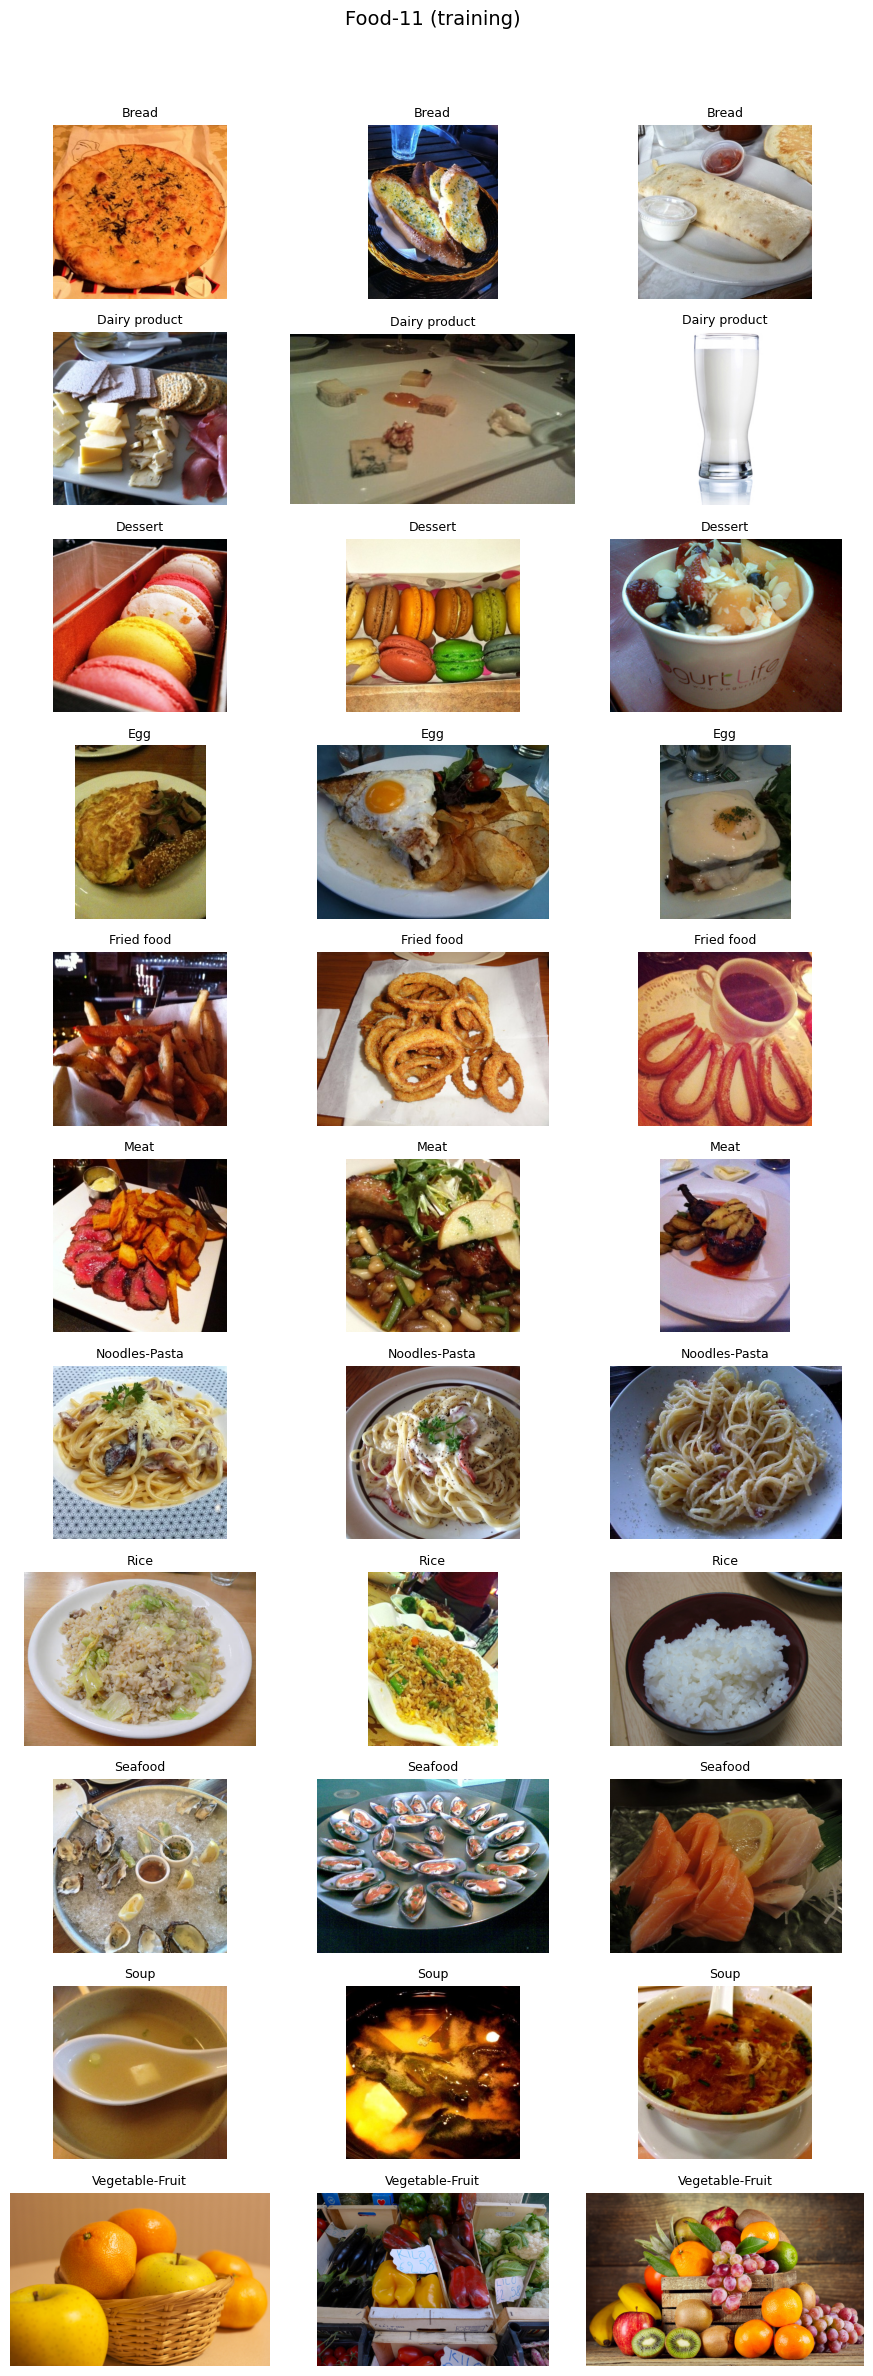

In [5]:
def show_balanced_grid(split_dir, classes, k=3):
    plt.figure(figsize=(k * 3, len(classes) * 2.2))
    idx = 1

    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        imgs = glob.glob(os.path.join(cls_dir, "*.*"))
        samples = random.sample(imgs, min(k, len(imgs)))

        for p in samples:
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(len(classes), k, idx)
            plt.imshow(img)
            plt.title(cls, fontsize=9)
            plt.axis("off")
            idx += 1

    plt.suptitle(f"Food-11 ({os.path.basename(split_dir)})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

show_balanced_grid(split_dir, classes, k=3)

## Image Enhancement – Contrast Improvement using CLAHE

In this step, we apply image enhancement to improve local contrast and visibility of food textures.
Contrast Limited Adaptive Histogram Equalization (CLAHE) is applied to the luminance channel in LAB color space, which enhances contrast while preserving color information.

At this stage, enhancement is demonstrated on a small random subset of images for visual verification.
The enhancement operation will later be integrated into the full processing pipeline and applied dynamically during feature extraction and model training.


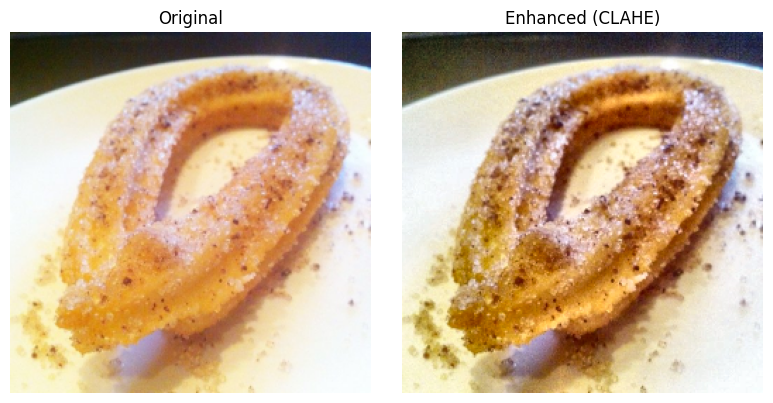

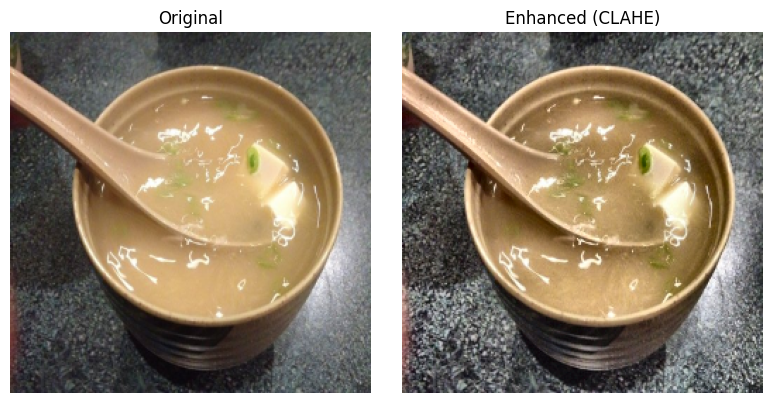

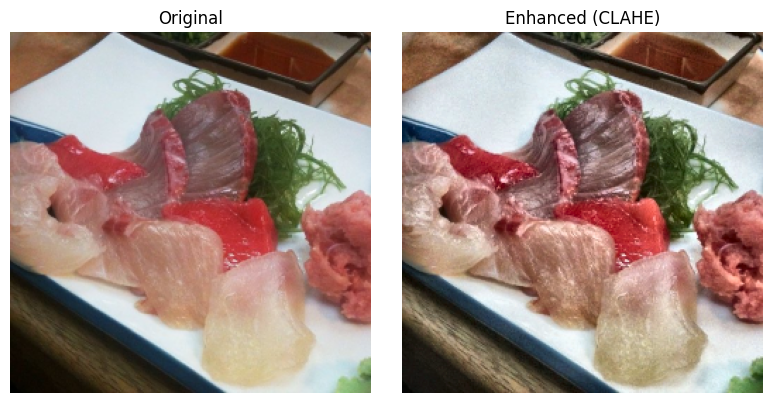

In [6]:
def enhance_clahe(bgr, clipLimit=2.0, tileGridSize=(8, 8)):
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    clahe = cv2.createCLAHE(
        clipLimit=clipLimit,
        tileGridSize=tileGridSize
    )
    L2 = clahe.apply(L)

    lab2 = cv2.merge([L2, A, B])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)


def show_before_after(img_path):
    bgr = cv2.imread(img_path)
    if bgr is None:
        return

    bgr = cv2.resize(bgr, (256, 256))
    enhanced = enhance_clahe(bgr)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced (CLAHE)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# collect image paths from training split
all_image_paths = glob.glob(
    os.path.join(split_dir, "*", "*.*")
)

for p in random.sample(all_image_paths, k=3):
    show_before_after(p)

## Image Restoration – Denoising using Non-Local Means

In this step, we apply image restoration to reduce sensor noise and small artifacts commonly present in real-world photos.
We use Non-Local Means denoising, which smooths noise while preserving edges and important structures.
This is validated on a small random subset before integrating it into the full pipeline.


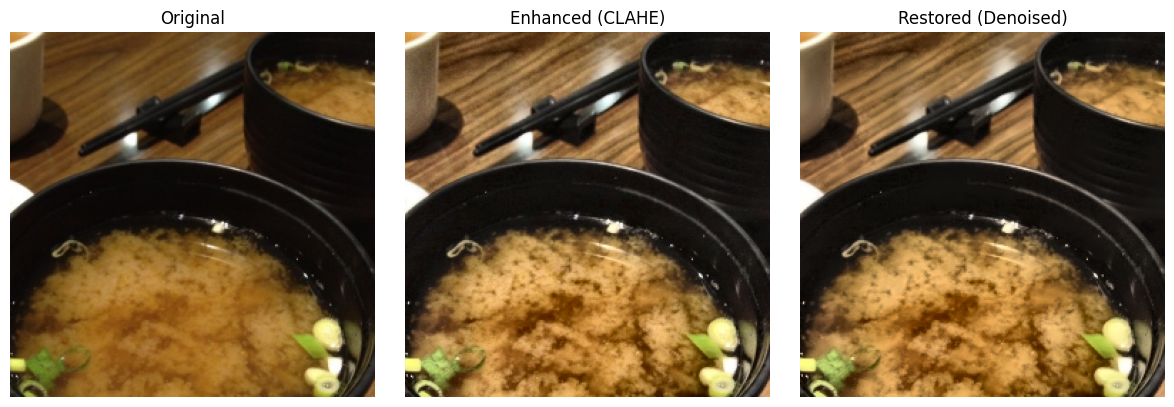

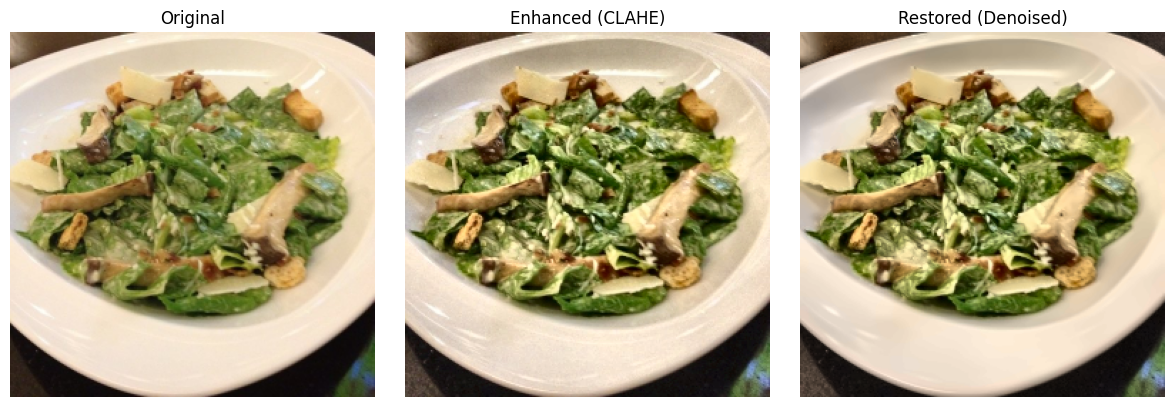

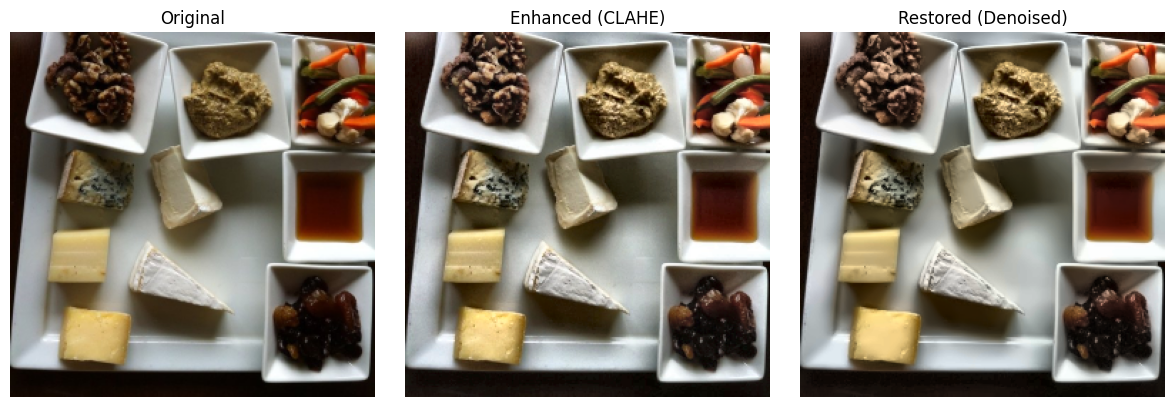

In [7]:
def restore_denoise_nlm(bgr, h=3, hColor=3):
    return cv2.fastNlMeansDenoisingColored(
        bgr, None,
        h=h, hColor=hColor,
        templateWindowSize=7,
        searchWindowSize=21
    )

def show_enhance_restore(img_path):
    bgr = cv2.imread(img_path)
    if bgr is None:
        return

    bgr = cv2.resize(bgr, (256, 256))
    enhanced = enhance_clahe(bgr)
    restored = restore_denoise_nlm(enhanced)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced (CLAHE)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(restored, cv2.COLOR_BGR2RGB))
    plt.title("Restored (Denoised)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# collect image paths from training split
all_image_paths = glob.glob(
    os.path.join(split_dir, "*", "*.*")
)

# visualize on 3 random images from training
for p in random.sample(all_image_paths, k=3):
    show_enhance_restore(p)

In [8]:
split_dir = os.path.join(DATASET_PATH, "training")

# Get original Food-11 classes
classes = sorted([
    d for d in os.listdir(split_dir)
    if os.path.isdir(os.path.join(split_dir, d))
])

print("Classes:", classes)
print("Number of classes:", len(classes))

# Collect image paths and labels
image_paths = []
labels = []

for label_id, cls in enumerate(classes):
    cls_dir = os.path.join(split_dir, cls)
    imgs = glob.glob(os.path.join(cls_dir, "*.*"))
    image_paths.extend(imgs)
    labels.extend([label_id] * len(imgs))

labels = np.array(labels)
print("Total images:", len(image_paths))


Classes: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
Number of classes: 11
Total images: 9866


# This cell extracts numerical features from all training images, preparing the data for machine learning. Specifically:

Reads and resizes images to a consistent 128×128 resolution.

Enhances image contrast using CLAHE to improve feature quality.

Extracts HSV color histograms as numerical features for classification.

Parallelizes feature extraction using joblib to speed up processing across all CPU cores.

Builds feature matrix X and label vector y aligned with each image.

Outcome:

X → 2D array: number of images × number of histogram features

y → 1D array: numeric labels corresponding to the original Food-11 classes

This cell is the data preparation step for training a classifier in the calorie estimation pipeline.

In [9]:
def lbp_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0,10), density=True)
    return hist

def extract_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    img = cv2.resize(img, (128,128))
    img = enhance_clahe(img)

    # HSV histogram
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_hist = cv2.calcHist([hsv],[0,1,2],None,[8,8,8],[0,180,0,256,0,256])
    hsv_hist = cv2.normalize(hsv_hist,hsv_hist).flatten()

    # LAB histogram
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_hist = cv2.calcHist([lab],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
    lab_hist = cv2.normalize(lab_hist,lab_hist).flatten()

    # LBP texture histogram
    lbp_hist = lbp_features(img)

    # Combine features
    feat = np.concatenate([hsv_hist, lab_hist, lbp_hist])
    return feat


In [10]:
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(extract_features)(p) for p in image_paths
)

X = np.array([r for r in results if r is not None])
y = np.array([labels[i] for i,r in enumerate(results) if r is not None])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19992260861740477s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03983569145202637s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08272814750671387s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18388032913208008s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [12]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=3, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [13]:
svm = SVC(
    kernel="rbf",
    C=20,
    gamma="scale",
    class_weight="balanced"
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

svm.fit(X_train_scaled, y_train)

SVC(C=20, class_weight='balanced')

In [14]:
logreg = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

logreg.fit(X_train_scaled, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, random_state=42)

In [15]:
models = {
    "Random Forest": (rf, X_val),
    "SVM": (svm, X_val_scaled),
    "Logistic Regression": (logreg, X_val_scaled)
}

for name, (model, Xv) in models.items():
    y_pred = model.predict(Xv)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))



Random Forest
Accuracy: 0.43059777102330293
              precision    recall  f1-score   support

           0       0.35      0.39      0.37       199
           1       0.83      0.23      0.36        86
           2       0.44      0.44      0.44       300
           3       0.35      0.32      0.33       197
           4       0.34      0.42      0.38       170
           5       0.43      0.52      0.47       265
           6       0.37      0.26      0.30        88
           7       0.56      0.16      0.25        56
           8       0.48      0.36      0.41       171
           9       0.49      0.49      0.49       300
          10       0.53      0.75      0.62       142

    accuracy                           0.43      1974
   macro avg       0.47      0.40      0.40      1974
weighted avg       0.45      0.43      0.42      1974


SVM
Accuracy: 0.43059777102330293
              precision    recall  f1-score   support

           0       0.34      0.41      0.37       19

In [16]:
dump(svm, "food_classifier_svm.pkl")
dump(scaler, "scaler.pkl")


['scaler.pkl']

In [17]:
svm_loaded = load("food_classifier_svm.pkl")
scaler_loaded = load("scaler.pkl")

X_val_scaled_loaded = scaler_loaded.transform(X_val)
y_pred_loaded = svm_loaded.predict(X_val_scaled_loaded)

from sklearn.metrics import accuracy_score
print("Loaded model accuracy:", accuracy_score(y_val, y_pred_loaded))


Loaded model accuracy: 0.43059777102330293


In [19]:
calories_df = pd.read_csv("Calories.csv")
calories_df


food_category  calories_per_100g
0             Bread                265
1     Dairy product                160
2           Dessert                350
3               Egg                155
4       Fried food                 300
5              Meat                250
6     Noodles-Pasta                140
7              Rice                130
8           Seafood                120
9              Soup                 60
10  Vegetable-Fruit                 50

In [31]:
label_map = {
    0: "Bread",
    1: "Dairy product",
    2: "Dessert",
    3: "Egg",
    4: "Fried food",
    5: "Meat",
    6: "Noodles-Pasta",
    7: "Rice",
    8: "Seafood",
    9: "Soup",
    10: "Vegetable-Fruit"
}

# --- Load calories CSV ---
calories_df = pd.read_csv("Calories.csv")

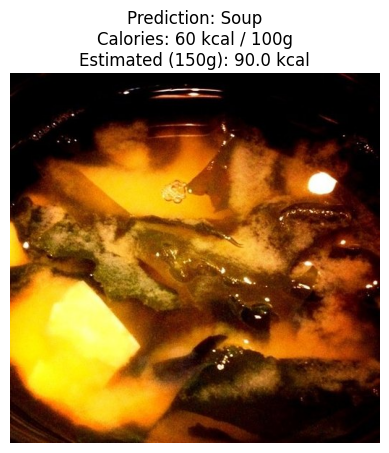

In [32]:
image_path = image_paths[9000]

features = extract_features(image_path)
features_scaled = scaler_loaded.transform([features])
pred_label = svm_loaded.predict(features_scaled)[0]

food_category = label_map[pred_label]

calories_per_100g = calories_df[
    calories_df["food_category"] == food_category
]["calories_per_100g"].values[0]

# example portion size
grams = 150
estimated_calories = (calories_per_100g / 100) * grams

# --- Display image ---
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.title(
    f"Prediction: {food_category}\n"
    f"Calories: {calories_per_100g} kcal / 100g\n"
    f"Estimated ({grams}g): {estimated_calories:.1f} kcal"
)
plt.show()
